## Imports

In [230]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm

import pandas as pd

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## Loading csv

In [200]:
df = pd.read_csv("./Wholesale customers data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [201]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [202]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [203]:
df.keys()

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [204]:
def get_uniques(df: pd.DataFrame, limit=-1):
    for key in df.keys():
        uqs = df[key].unique()

        print(key)
        if limit >=0 and len(uqs) > limit:
            print("Too Many Values")
        else:
            print(uqs)
        print()
get_uniques(df)

Channel
[2 1]

Region
[3 1 2]

Fresh
[ 12669   7057   6353  13265  22615   9413  12126   7579   5963   6006
   3366  13146  31714  21217  24653  10253   1020   5876  18601   7780
  17546   5567  31276  26373  22647  16165   9898  14276   4113  43088
  18815   2612  21632  29729   1502    688  29955  15168   4591  56159
  24025  19176  10850    630   9670   5181   3103  44466  11519   4967
   6269   3347  40721    491  27329   5264   4098   5417  13779   6137
   8590  35942   7823   9396   4760     85      9  19913   2446   8352
  16705  18291   4420  19899   8190  20398    717  12205  10766   1640
   7005    219  10362  20874  11867  16117  22925  43265   7864  24904
  11405  12754   9198  11314   5626      3     23    403    503   9658
  11594   1420   2932  56082  14100  15587   1454   8797   1531   1406
  11818  12579  19046  14438  18044  11134  11173   6990  20049   8258
  17160   4020  12212  11170  36050  76237  19219  21465    140  42312
   7149   2101  14903   9434   7388   63

## Preprocessing

In [205]:
# All values seem to be non-null

In [206]:
# Outlier check

df_z = (df - df.mean())/df.std()

(df_z.abs() > 3).sum()

Channel              0
Region               0
Fresh                7
Milk                 9
Grocery              7
Frozen               6
Detergents_Paper    10
Delicassen           4
dtype: int64

In [207]:
# Few outliers so we are safe to remove them

df.drop(df[(df_z.abs() > 3).any(axis=1)].index, inplace=True)

df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,1.314010,2.548309,10711.758454,4871.920290,6814.043478,2549.898551,2373.393720,1237.939614
std,0.464682,0.769475,9819.217756,4555.665546,6456.160715,2916.683284,3208.707909,1217.399162
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3063.250000,1477.750000,2116.000000,676.750000,252.750000,395.000000
50%,1.000000,3.000000,8040.000000,3530.000000,4528.000000,1447.000000,772.000000,881.000000
75%,2.000000,3.000000,15657.000000,6908.500000,9762.250000,3204.250000,3660.500000,1681.750000
max,2.000000,3.000000,49063.000000,25862.000000,34792.000000,16919.000000,17120.000000,7844.000000


### Scaling Features

In [208]:
df = (df - df.mean()) / df.std()

df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02
mean,-1.716287e-16,-4.462346e-16,-4.719789e-17,1.029772e-16,-6.865147e-17,4.290717e-17,-1.716287e-17,-9.439577e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.757520e-01,-2.012163e+00,-1.090592e+00,-1.057347e+00,-1.054968e+00,-8.656746e-01,-7.387378e-01,-1.014408e+00
25%,-6.757520e-01,-7.125758e-01,-7.789326e-01,-7.450438e-01,-7.276838e-01,-6.422187e-01,-6.609027e-01,-6.924102e-01
50%,-6.757520e-01,5.870118e-01,-2.720948e-01,-2.945608e-01,-3.540871e-01,-3.781345e-01,-4.990774e-01,-2.931985e-01
75%,1.476258e+00,5.870118e-01,5.036289e-01,4.470433e-01,4.566501e-01,2.243478e-01,4.011292e-01,3.645562e-01
max,1.476258e+00,5.870118e-01,3.905733e+00,4.607467e+00,4.333529e+00,4.926521e+00,4.595808e+00,5.426372e+00


In [209]:
X = df

## Cluster Training and evaluation

In [210]:
def search(X, params, model_class, method="grid", metric="silhouette", n_iter=30):
    metric_func = {
        "silhouette": silhouette_score,
        "dbi": davies_bouldin_score,
        "chi": calinski_harabasz_score,
    }[metric]

    class WrapperModel(BaseEstimator, ClusterMixin):
        def __init__(self, **kwargs):
            # ✅ Store kwargs so sklearn knows about them
            self.kwargs = kwargs

        def set_params(self, **params):
            self.kwargs.update(params)
            return self

        def get_params(self, deep=True):
            return self.kwargs.copy()

        def fit(self, X, y=None):
            self.model_ = model_class(**self.kwargs)
            self.labels_ = self.model_.fit_predict(X)
            return self

        def score(self, X, y=None):
            if len(set(self.labels_)) <= 1:
                return -1000 if metric in ["silhouette", "chi"] else 1000
            score = metric_func(X, self.labels_)
            return -score if metric == "dbi" else score
    
    dummy_cv = [(np.arange(len(X)), np.arange(len(X)))]

    if method == "grid":
        searcher = GridSearchCV(
            estimator=WrapperModel(),
            param_grid=params,
            verbose=1,
            cv=dummy_cv,
            n_jobs=-1,
        )
    else:
        searcher = RandomizedSearchCV(
            estimator=WrapperModel(),
            param_distributions=params,
            verbose=1,
            cv=dummy_cv,
            n_iter=n_iter,
            n_jobs=-1,
        )

    searcher.fit(X)

    print("Best params:", searcher.best_params_)
    print(f"Best {metric} score:", searcher.best_score_)
    print()
    return searcher.best_estimator_, searcher.best_params_, searcher.best_score_

In [211]:
models = {}

def eval(Name, model, X, labels):    
    score_sh = silhouette_score(X, labels)
    score_db = davies_bouldin_score(X, labels)
    score_ch = calinski_harabasz_score(X, labels)

    print("Silhouette Score:", score_sh)
    print("Davies–Bouldin Index:", score_db)
    print("Calinski–Harabasz Index:", score_ch)

    models[Name] = {
        "Name": Name,
        "Model": model,
        "labels": labels,
        "metrics": {
            "score_sh": score_sh,
            "score_db": score_db,
            "score_ch": score_ch,
        }
    }

### KMeans

In [212]:
params = {
    "n_clusters": list(range(2, 100)),
    "random_state": [42],
}

search(X, params, KMeans, method="grid", metric="silhouette");
search(X, params, KMeans, method="grid", metric="dbi");
search(X, params, KMeans, method="grid", metric="chi");

Fitting 1 folds for each of 98 candidates, totalling 98 fits
Best params: {'n_clusters': 2, 'random_state': 42}
Best silhouette score: 0.35102559061514965

Fitting 1 folds for each of 98 candidates, totalling 98 fits
Best params: {'n_clusters': 99, 'random_state': 42}
Best dbi score: -0.7900541120322981

Fitting 1 folds for each of 98 candidates, totalling 98 fits
Best params: {'n_clusters': 2, 'random_state': 42}
Best chi score: 199.47723211994588



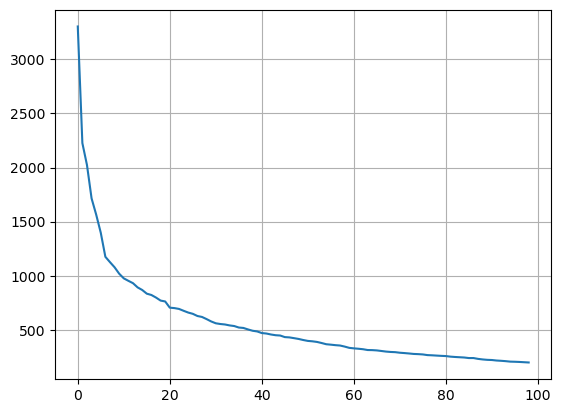

In [213]:
intertias = []

for k in range(1,100):
    kmean = KMeans(n_clusters=k, random_state=42)
    kmean.fit(X)
    # labels = kmean.labels_
    # centers = kmean.cluster_centers_
    intertias.append(kmean.inertia_)

plt.plot(intertias);
plt.grid();

# 20 is a good elbow

In [214]:
kmean = KMeans(n_clusters=20, random_state=42)
kmean.fit(X)
labels = kmean.labels_

eval("KMeans", kmean, X, labels)

Silhouette Score: 0.22442835965126814
Davies–Bouldin Index: 1.445003682140416
Calinski–Harabasz Index: 69.1979890629256


### Hierarchical

In [215]:
class HierarchicalWrapper:
    def __init__(self, t=2, method="ward"):
        self.t = t
        self.method = method
        self._Z = None   # will hold the linkage matrix
        self._X = None   # keep X if needed

    def fit(self, X, y=None):
        self._X = X
        self._Z = linkage(X, method=self.method)
        return self

    @property
    def labels_(self):
        if self._Z is None:
            raise ValueError("Model not fitted yet. Call .fit(X) first.")
        return fcluster(self._Z, t=self.t, criterion="maxclust")

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.labels_
    
params = {
    "t": list(range(2, 10)),
    "method": ["ward", "complete", "average", "single"]
}

search(X, params, HierarchicalWrapper, method="grid", metric="silhouette");
search(X, params, HierarchicalWrapper, method="grid", metric="dbi");
search(X, params, HierarchicalWrapper, method="grid", metric="chi");

Fitting 1 folds for each of 32 candidates, totalling 32 fits
Best params: {'method': 'single', 't': 2}
Best silhouette score: 0.39825637913430123

Fitting 1 folds for each of 32 candidates, totalling 32 fits
Best params: {'method': 'single', 't': 2}
Best dbi score: -0.4651900503730936

Fitting 1 folds for each of 32 candidates, totalling 32 fits
Best params: {'method': 'ward', 't': 2}
Best chi score: 191.34688484634316



In [216]:
# Perform hierarchical clustering (Ward's method)
Z = linkage(X, method='ward')

clusters = fcluster(Z, t=2, criterion='maxclust')

eval("Hierarchical", Z, X, clusters)

Silhouette Score: 0.3464660865788527
Davies–Bouldin Index: 1.2868043821600255
Calinski–Harabasz Index: 191.34688484634316


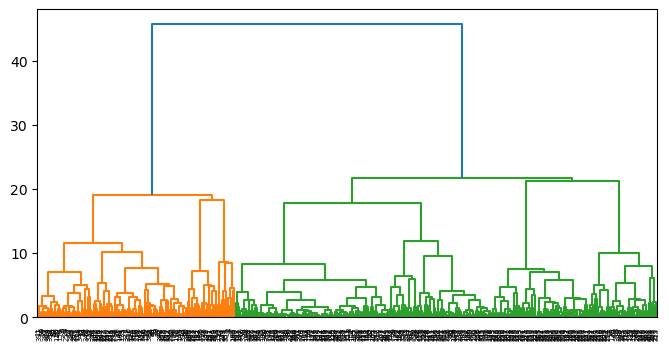

In [217]:
# Plot dendrogram
plt.figure(figsize=(8, 4))
dendrogram(Z);

### DBSCAN

In [218]:
params = {
    "eps": np.linspace(0.1, 2.0, 20),
    "min_samples": list(range(1,10)),
}

best_model, best_params, best_score = search(X, params, DBSCAN, method="grid", metric="silhouette")

Fitting 1 folds for each of 180 candidates, totalling 180 fits
Best params: {'eps': np.float64(2.0), 'min_samples': 4}
Best silhouette score: 0.33160555947846404



In [219]:
db = DBSCAN(eps=2, min_samples=4)
db.fit(X)
labels = db.labels_

eval("DBSCAN", db, X, labels)

Silhouette Score: 0.33160555947846404
Davies–Bouldin Index: 2.1360379799360394
Calinski–Harabasz Index: 108.90110333762323


### MeanShift

In [220]:
ms = MeanShift(bandwidth=None)
ms.fit(X)
labels = ms.predict(X)

eval("MeanShift", ms, X, labels)

Silhouette Score: 0.28536086529846033
Davies–Bouldin Index: 1.5009312018373087
Calinski–Harabasz Index: 33.7644296397798


## Evaluation

In [221]:
comparison = {
    k: v["metrics"] for k, v in models.items()
}

comparison = pd.DataFrame.from_dict(comparison, orient="index")

comparison_sh = comparison.sort_values(by="score_sh", ascending=False)
comparison_db = comparison.sort_values(by="score_db", ascending=True)
comparison_ch = comparison.sort_values(by="score_ch", ascending=False)

In [222]:
comparison_sh

,score_sh,score_db,score_ch
Hierarchical,0.346466,1.286804,191.346885
DBSCAN,0.331606,2.136038,108.901103
MeanShift,0.285361,1.500931,33.764430
KMeans,0.224428,1.445004,69.197989


In [223]:
comparison_db

,score_sh,score_db,score_ch
Hierarchical,0.346466,1.286804,191.346885
KMeans,0.224428,1.445004,69.197989
MeanShift,0.285361,1.500931,33.764430
DBSCAN,0.331606,2.136038,108.901103


In [224]:
comparison_ch

,score_sh,score_db,score_ch
Hierarchical,0.346466,1.286804,191.346885
DBSCAN,0.331606,2.136038,108.901103
KMeans,0.224428,1.445004,69.197989
MeanShift,0.285361,1.500931,33.764430


## Visualization

In [ ]:
def plot_clusters(X, labels, method=None):
    assert method in ["pca", "tsne", None]

    if method is None:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plot_clusters(X, labels, "pca")
        plt.subplot(1,2,2)
        plot_clusters(X, labels, "tsne")

        return
    
    def get_colormap(n_clusters):
        """Pick a good colormap depending on number of clusters"""
        if n_clusters <= 2:
            return ["#1f77b4", "#ff7f0e"]  # nice blue & orange
        elif n_clusters <= 10:
            return cm.get_cmap("tab10", n_clusters)
        else:
            return cm.get_cmap("tab20", n_clusters)
    
    n_clusters = len(np.unique(labels))
    cmap = get_colormap(n_clusters)    

    if method == "pca":
        model = PCA(n_components=2)
    elif method == "tsne":
        model = TSNE(n_components=2, perplexity=30, random_state=42)
    X_2d = model.fit_transform(X)

    # scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", s=30, alpha=0.7)

    scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap=cmap, s=30, alpha=0.7)
    if n_clusters > 2:
        cmap = cm.get_cmap("tab10" if n_clusters <= 10 else "tab20", n_clusters if n_clusters <= 10 else 20)
        scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap=cmap, s=30, alpha=0.7)
        
        cbar = plt.colorbar(scatter, label="Cluster")
        cbar.set_ticks(np.unique(labels))   # force ticks at cluster ids
        cbar.set_ticklabels(np.unique(labels))
    else:
        colors = np.array(["#1f77b4", "#ff7f0e"])  # blue & orange
        for cluster_id in np.unique(labels):
            mask = labels == cluster_id
            plt.scatter(X_2d[mask,0], X_2d[mask,1], 
                        c=colors[cluster_id % 2], label=f"Cluster {cluster_id}",
                        s=30, alpha=0.7)
        # plt.legend()
    # plt.colorbar(scatter, label="Cluster")

    plt.title(f"Clusters ({method.upper()})")

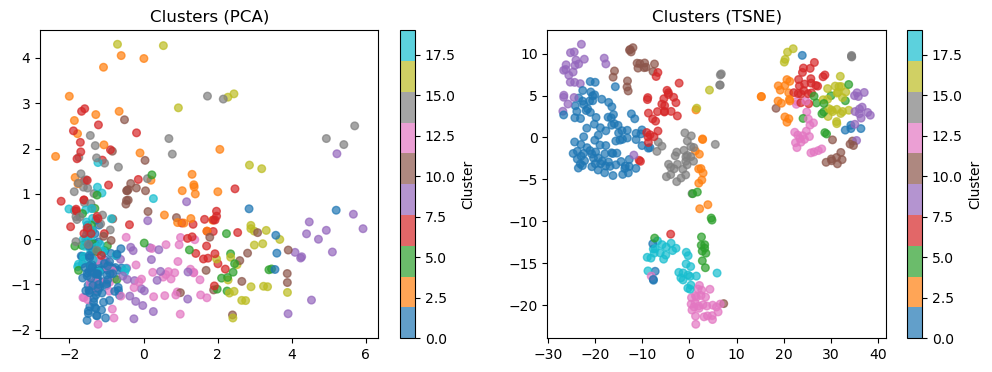

In [262]:
plot_clusters(X, models["KMeans"]["labels"])

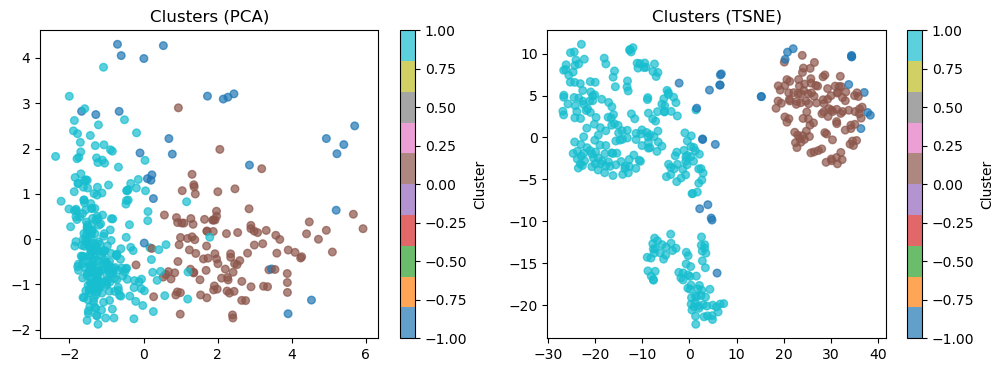

In [263]:
plot_clusters(X, models["DBSCAN"]["labels"])

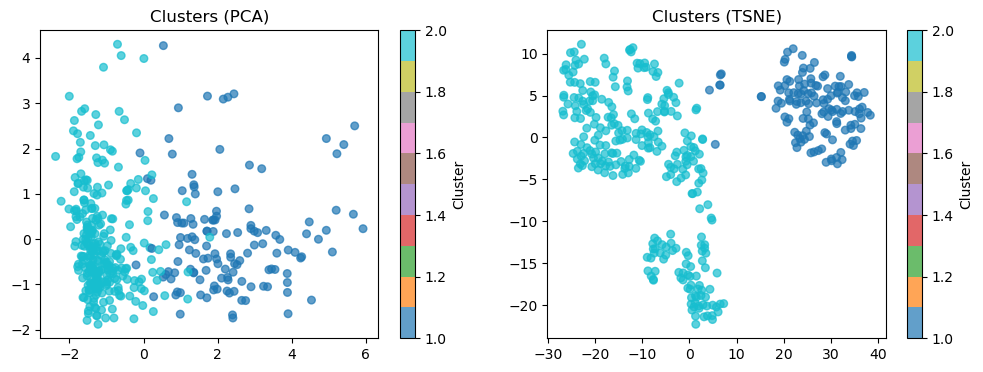

In [264]:
plot_clusters(X, models["Hierarchical"]["labels"])

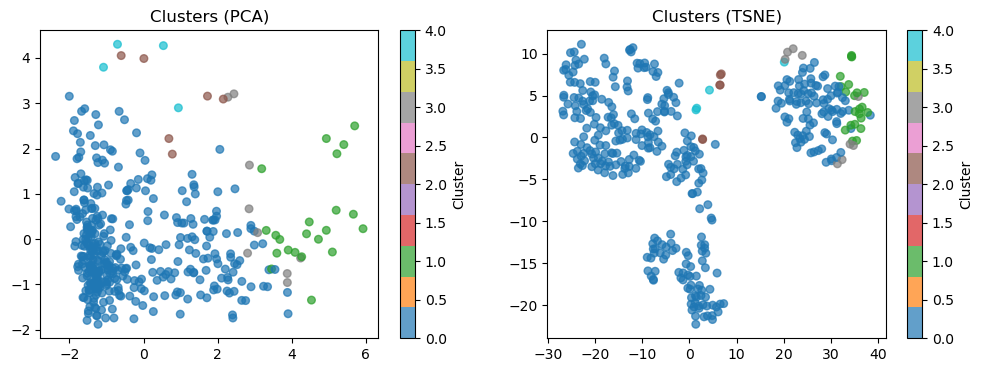

In [265]:
plot_clusters(X, models["MeanShift"]["labels"])

## Interpretation